In [1]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


In [20]:
cwd = os.getcwd()

# Go one folder back
parent_dir = os.path.dirname(cwd)

# Specify the relative path to the audio file from the parent directory
relative_path = r"Dataset\HindiDigits"
relative_path_mfcc = r"Dataset\HindiDigitsMFCC"
speech_path = os.path.join(parent_dir, relative_path)

In [4]:
def feature_extractor(sound_path, window_size):
    # Load the audio file
    signal, sr = librosa.load(sound_path)
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13,sr = sr, hop_length=window_size)
    
    # Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features
#     return mfccs


In [5]:
def build_dataset(sound_path=speech_path, window_size=512):
    # Define the path to the sound files
    path = Path(sound_path)
    # Retrieve the list of files in the directory
    files = sorted([file for file in path.iterdir() if file.is_file()])
    
    # Initialize lists to store training and testing data
    Train = []
    Test = []
    
    # Initialize a dictionary to store data for each digit
    data = dict()
    
    # Get the total number of files
    n = len(files)
    # Iterate over each file
    for i in range(n):
        print(str(files[i]))
        
        feature = feature_extractor(sound_path=str(files[i]), window_size=window_size)[3]
        pattern = r'/(\d+)_'

        # Use re.search() to find the first match of the pattern in the file path
        match = re.search(pattern, str(files[i]))

        if match:
            # Extract the digit from the match
            digit = match.group(1)
            print("The digit represented in the file path is:", digit)
        else:
            print("No digit found in the file path.")

#         Extract the digit label from the filename
#         digit = files[i].name[0]

        transposed_mfcc = feature.T

        # Create a DataFrame from the transposed array
        df = pd.DataFrame(transposed_mfcc)

        # Add the file name as the first column
        df.insert(0, 'File Name', os.path.basename(files[i]))
        df.insert(1, 'digit', digit)

        # Optionally, you can rename the columns if you want
        column_names = ['File Name'] + ['digit'] + [f"Feature_{i+1}" for i in range(39)]
        df.columns = column_names

        # Check if the digit is already in the data dictionary
        if digit not in data.keys():
            # If not, create a new list for that digit
            data[digit] = []
            # Append the feature to the test set
            Test.append(df)
        else:
            # If the digit is already in the dictionary
            if np.random.rand() < 0.1:
                # Randomly assign 10% of the samples to the test set
                Test.append(df)
                
            else:
                # Assign the rest of the samples to the training set
                Train.append(df)
            
            # Append the feature to the data dictionary
        data[digit].append(feature)
    # Concatenate all DataFrames into a single DataFrame
    Training = pd.concat(Train, ignore_index=True)
    Testing = pd.concat(Test, ignore_index=True)
    # Return the training and testing data along with the data dictionary
    return Training, Testing, data


In [6]:
#Experiment Here 

audio_file  = speech_path + "/1_01.wav"
signal, sr = librosa.load(audio_file)
print(sr)
# Call the feature_extractor function with window size (default is 512 generated 68 frames for the given audio file)
# Changing to 256 gives 135 frames
a, b, c, d = feature_extractor(audio_file,512)
# d = feature_extractor(audio_file,512)
d.shape


22050


(39, 12)

In [12]:
def MelSpectrogram(mfccs, delta_mfccs, delta2_mfccs, mfccs_features):
    print("MFCCs shape:", mfccs.shape)
    print("Delta MFCCs shape:", delta_mfccs.shape)
    print("Delta2 MFCCs shape:", delta2_mfccs.shape)
    print("Concatenated MFCCs features shape:", mfccs_features.shape)
    
    # Plot MFCCs
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB', cmap='hot')
    plt.title('MFCCs')
    
#     # Plot delta MFCCs
    plt.subplot(1, 3, 2)
    librosa.display.specshow(delta_mfccs, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Delta MFCCs')
    
#     # Plot delta2 MFCCs
    plt.subplot(1, 3, 3)
    librosa.display.specshow(delta2_mfccs, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Delta2 MFCCs')
    
    plt.tight_layout()
    plt.show()


MFCCs shape: (13, 12)
Delta MFCCs shape: (13, 12)
Delta2 MFCCs shape: (13, 12)
Concatenated MFCCs features shape: (39, 12)


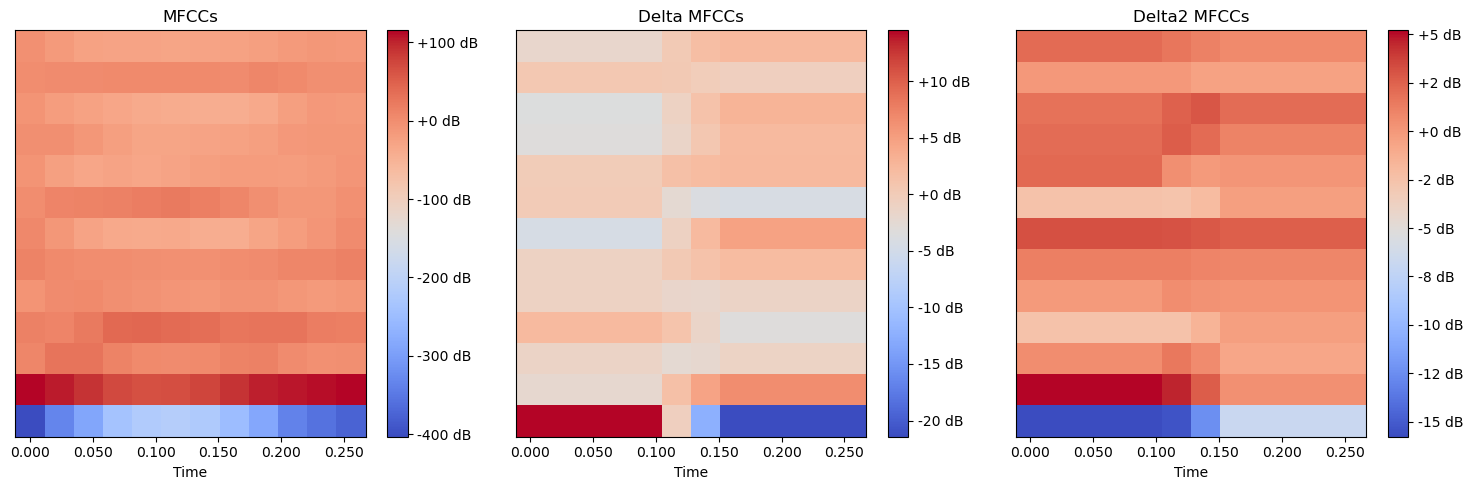

In [13]:
# Assuming you have the sampling rate stored in a variable named `sr`
MelSpectrogram(a, b, c, d)
# MelSpectrogram(d)

In [39]:
#!!! Main change to be done here
#Change Window size here
Training, Testing, data = build_dataset(window_size=512)
# Define the output directory
output_folder = parent_dir  # Output directory

# Check if the output directory exists, if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save DataFrame as CSV in the output directory
output_file = os.path.join(output_folder,"Train.csv")
Training.to_csv(output_file, index=False)
output_file = os.path.join(output_folder,"Test.csv")
Testing.to_csv(output_file, index=False)


The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_02.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_03.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_04.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_05.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_06.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_07.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_08.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_09.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_10.wav
The digit represented in the file path is: 8
/kaggle/input/hindidigits-single/working/8_11.wav
The digit represented in the file path is: 8
/kagg

# PCA code


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class PCA:
    def __init__(self, n_component):
        self.n_component = n_component

    def __covarience_matrix(self, X):
        # Calculate the covariance matrix of the data
        return X.T.dot(X)

    def __p_component_values(self, COV):
        # Compute eigenvalues and eigenvectors of the covariance matrix
        eigenValues, eigenVectors = np.linalg.eig(COV)
        idx = eigenValues.argsort()[::-1]
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:, idx]
        return eigenValues, eigenVectors

    def fit(self, X):
        # Fit PCA to the data
        self.COV = self.__covarience_matrix(X)
        self.eigenValues, self.eigenVectors = self.__p_component_values(self.COV)

    def transform(self, X):
        # Transform the data into the PCA space
        self.eigen_pairs = np.concatenate((np.abs(self.eigenValues).reshape(self.eigenValues.size, 1), self.eigenVectors), axis=1)
        self.eigen_pairs = np.array(sorted(self.eigen_pairs, key=lambda a_entry: a_entry[0], reverse=True))
        self.eigenVectors = self.eigen_pairs[:, 1:]

        if self.n_component > 0:
            eigenVectors = np.delete(self.eigenVectors, range(self.n_component, self.eigenVectors.shape[1]), axis=0)[::-1]
            X_transform = X.dot(eigenVectors.T)

        else:
            raise Exception("Minimum dimension should be more than 0")

        return X_transform

    def fit_transform(self, X):
        # Fit PCA to the data and transform it
        self.fit(X)
        return self.transform(X)

def StandardScalar(X, centering=True, scaling=True):
    # Standardize the features of the data
    X = X.astype(float)

    if centering:
        X = X - X.mean(axis=0)
    if scaling:
        X = X / np.std(X, axis=0)

    return X

def plot_scree_plot(eigen_values, n_components):
    # Plot the scree plot showing explained variance ratio
    total_variance = np.sum(eigen_values)
    explained_variance_ratio = eigen_values / total_variance * 100
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(eigen_values) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(eigen_values) + 1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio (%)')
    plt.xlabel('Principal components')
    plt.title('Scree Plot')
    plt.xticks(range(1, len(eigen_values) + 1))
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def plot_correlation_heatmap(csv_file_path, exclude_columns=['File Name', 'digit']):
    # Plot the correlation matrix heatmap
    # Read the CSV file and exclude specified columns
    df = pd.read_csv(csv_file_path, usecols=lambda column: column not in exclude_columns)
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix Heatmap')
    plt.show()


In [15]:
def process_csv(csv_file, n_components):
    
    # Read the CSV file excluding the 'File Name' and 'digit' columns
    df = pd.read_csv(csv_file, usecols=lambda column: column not in ['File Name', 'digit'])
    df = df.iloc[:,0:12]
    # Extract numeric columns for scaling
    X = df.select_dtypes(include=np.number).values

    X_scaled = StandardScalar(X)

    # Perform principal component analysis
    pca = PCA(n_component=n_components)
    X_transform = pca.fit_transform(X_scaled)
    
    # Plot the scree plot
    plot_scree_plot(pca.eigenValues, n_components=2)
    return X_transform

# Scree Plots for Digit Features

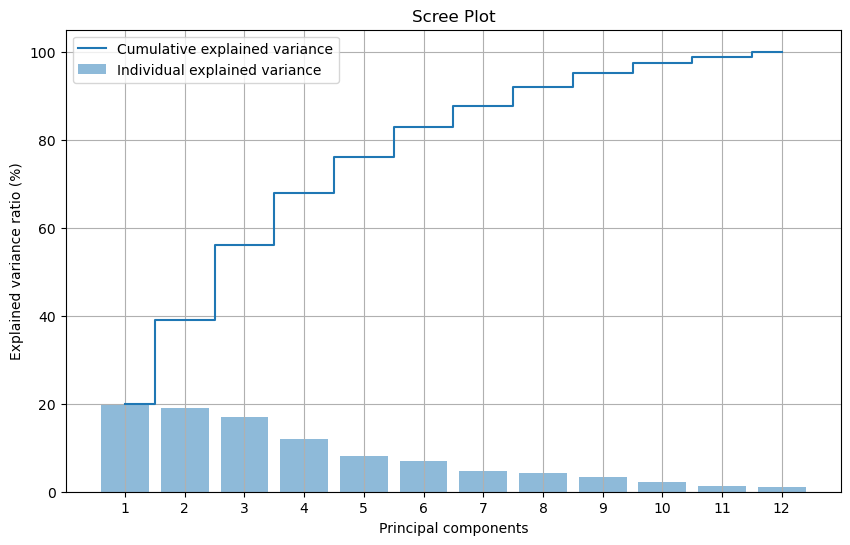

array([[ 1.30328337, -0.48470002],
       [ 0.60550854, -0.40695792],
       [-0.37830894,  0.07801323],
       ...,
       [ 0.07944632, -0.91630616],
       [-0.05329557, -1.15619447],
       [ 0.14409939, -1.36337848]])

In [22]:
mfcc_path_train = os.path.join(parent_dir, relative_path_mfcc) + "\Train.csv"
mfcc_path_test = os.path.join(parent_dir, relative_path_mfcc) + "\Test.csv"
process_csv(mfcc_path_train,2)

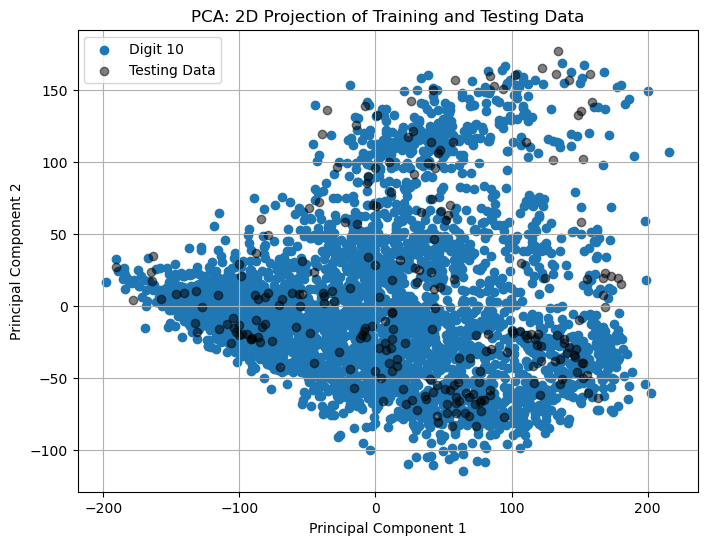

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Read training data from file 'Train.csv' and extract columns 1 to 13 exclusive
train_df = pd.read_csv(mfcc_path_train, usecols=range(1, 15))

# Read testing data from file 'Test.csv' and extract columns 1 to 13 exclusive
test_df = pd.read_csv(mfcc_path_test, usecols=range(1, 15))

# Assuming the digit is in column 1 of the train dataset
digits = train_df.iloc[:, 0]

# Step 1: Perform PCA on the training data
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_df)

# Step 2: Project the testing data onto the principal components obtained from the training data
test_pca = pca.transform(test_df)

# Get unique digits
unique_digits = np.unique(digits)

# Assign a color to each digit
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_digits)))

# Visualize the data in 2 dimensions
plt.figure(figsize=(8, 6))

# Plot training data
for i, digit in enumerate(unique_digits):
    mask = digits == digit
    plt.scatter(train_pca[mask, 0], train_pca[mask, 1], label=f'Digit {int(digit)}', color=colors[i])

# Plot testing data
plt.scatter(test_pca[:, 0], test_pca[:, 1], label='Testing Data', color='black', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: 2D Projection of Training and Testing Data')
plt.legend()
plt.grid(True)
plt.show()


0       10
1       10
2       10
3       10
4       10
        ..
3496    10
3497    10
3498    10
3499    10
3500    10
Name: digit, Length: 3501, dtype: int64


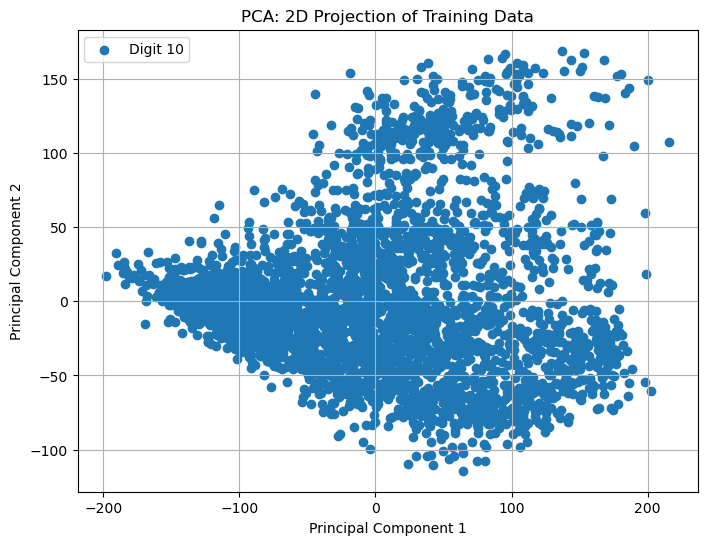

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Read training data from file 'Train.csv' and extract columns 1 to 13 exclusive
train_df = pd.read_csv(mfcc_path_train, usecols=range(1, 15))

# Assuming the digit is in column 1 of the train dataset
digits = train_df.iloc[:, 0]
print(digits)

# Step 1: Perform PCA on the training data
pca = PCA(n_components=2)
# train_pca = pca.fit_transform(train_df)

# Get unique digits
unique_digits = np.unique(digits)

# Assign a color to each digit
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_digits)))

# Visualize the data in 2 dimensions
plt.figure(figsize=(8, 6))

# Plot training data
for i, digit in enumerate(unique_digits):
    mask = digits == digit
    plt.scatter(train_pca[mask, 0], train_pca[mask, 1], label=f'Digit {int(digit)}', color=colors[i])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: 2D Projection of Training Data')
plt.legend()
plt.grid(True)
plt.show()


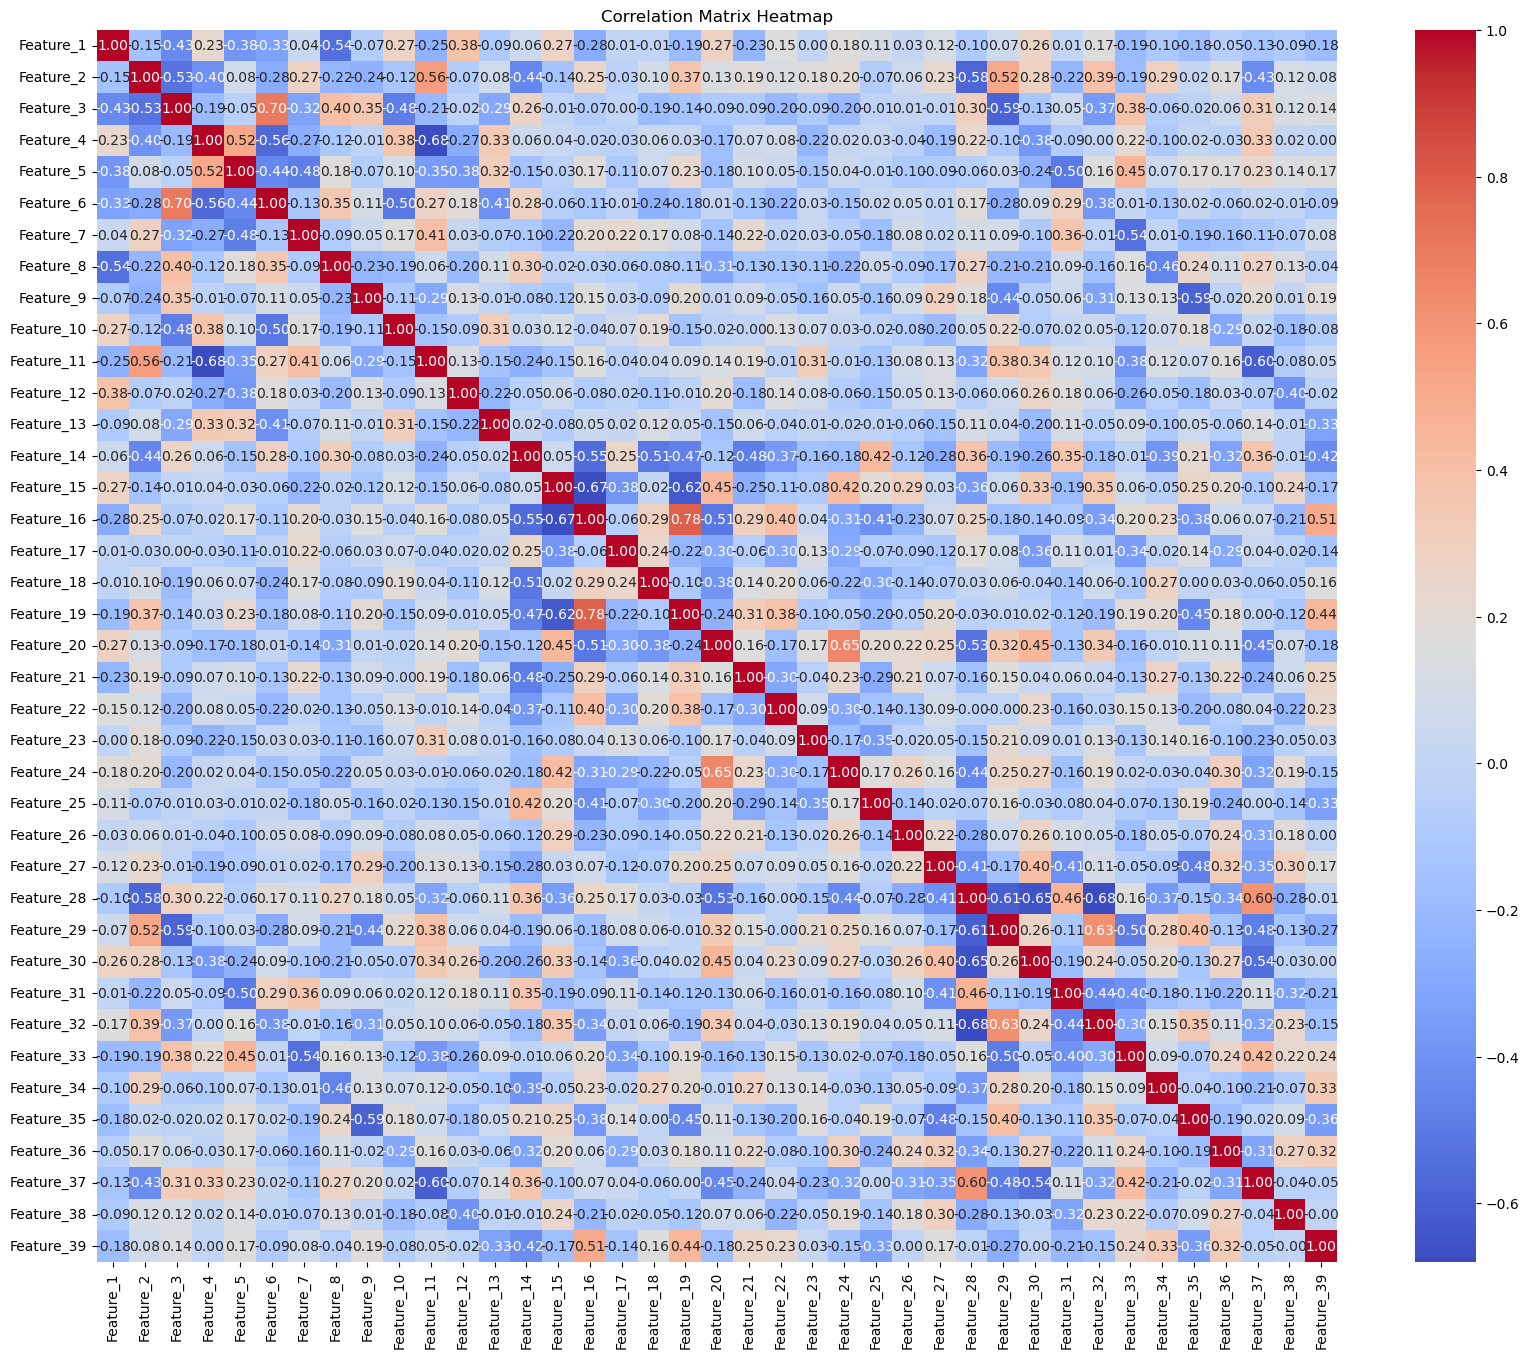

In [28]:
# Example usa

plot_correlation_heatmap(mfcc_path_test)


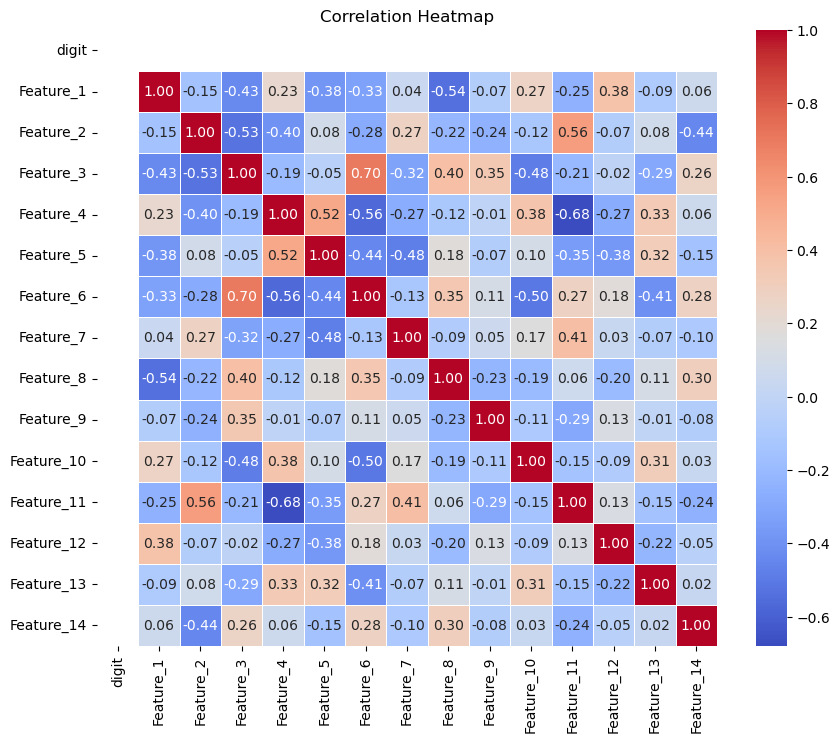

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(csv_file_path, num_columns):
    """
    Plot correlation heatmap between columns in a CSV file.

    Parameters:
    - csv_file_path (str): Path to the CSV file.
    - num_columns (int): Number of columns to consider for correlation.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path, usecols=range(1, num_columns + 1))

    # Calculate the correlation matrix
    corr = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage
num_columns = 15
plot_correlation_heatmap(mfcc_path_test, num_columns)


# Reducing Noise 

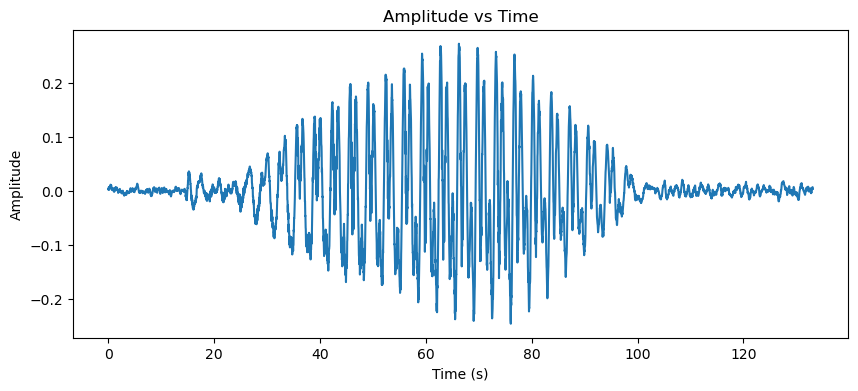

In [32]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_file = os.path.join(parent_dir, relative_path) + "/1_01.wav"
y, sr = librosa.load(audio_file)

# Calculate the time array
time = librosa.times_like(y, sr=sr)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()


In [33]:
pip install librosa matplotlib IPython pedalboard noisereduce

     ---------------------------------------- 3.1/3.1 MB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


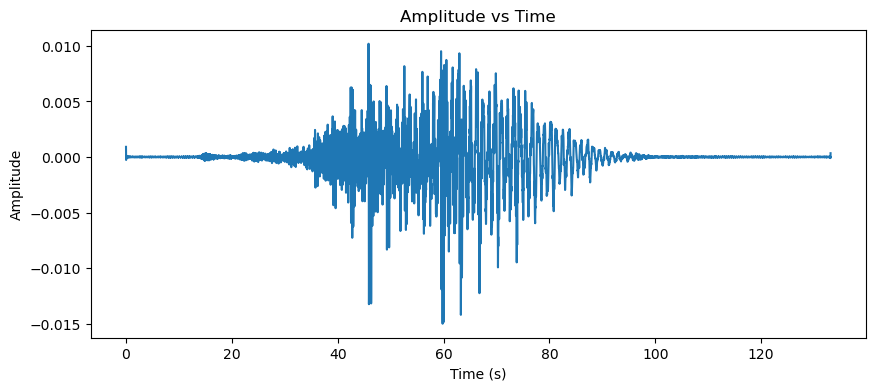

In [34]:
import noisereduce as nr
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

data, samplerate = sf.read(audio_file)
# reduce noise
y_reduced_noise = nr.reduce_noise(y=data, sr=samplerate,stationary=True)
# save audio
sf.write('Vocals_reduced.wav', y_reduced_noise, samplerate, subtype="PCM_24")
# load and play audio

time = librosa.times_like(y_reduced_noise, sr=samplerate)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y_reduced_noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()

In [35]:
ipd.Audio('./Vocals_reduced.wav')

# Noise Reduce Doesn't Work on Dual Audio Files

In [37]:
import os
import warnings
import noisereduce as nr
import soundfile as sf

# Suppress librosa warnings
warnings.filterwarnings('ignore', message='n_fft=1024 is too large for input signal of length=2')

# Directory containing audio files
directory = os.path.join(parent_dir, relative_path)

# Output directory for saving processed files
output_directory = './'

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".wav"): 
        # Check if the file is a WAV file
        file_path = os.path.join(directory, filename)
        
        # Read audio file
        data, samplerate = sf.read(file_path)
        
        # Reduce noise
        y_reduced_noise = nr.reduce_noise(y=data, sr=samplerate, stationary=True)
        
        # Save audio with reduced noise using the same filename
        output_file_path = os.path.join(output_directory, filename)
        sf.write(output_file_path, y_reduced_noise, samplerate, subtype="PCM_24")
        
        print(f"Noise reduction completed for {filename}")

print("All files processed successfully.")

Noise reduction completed for 1_01.wav
Noise reduction completed for 1_02.wav
Noise reduction completed for 1_03.wav
Noise reduction completed for 1_04.wav
Noise reduction completed for 1_05.wav
Noise reduction completed for 1_06.wav
Noise reduction completed for 1_07.wav
Noise reduction completed for 1_08.wav
Noise reduction completed for 1_09.wav
Noise reduction completed for 1_10.wav
Noise reduction completed for 1_11.wav
Noise reduction completed for 1_12.wav
Noise reduction completed for 1_13.wav
Noise reduction completed for 1_14.wav
Noise reduction completed for 1_15.wav
Noise reduction completed for 1_16.wav
Noise reduction completed for 1_17.wav
Noise reduction completed for 1_18.wav
Noise reduction completed for 1_19.wav
Noise reduction completed for 1_20.wav
Noise reduction completed for 2_01.wav
Noise reduction completed for 2_02.wav
Noise reduction completed for 2_03.wav
Noise reduction completed for 2_04.wav
Noise reduction completed for 2_05.wav
Noise reduction completed

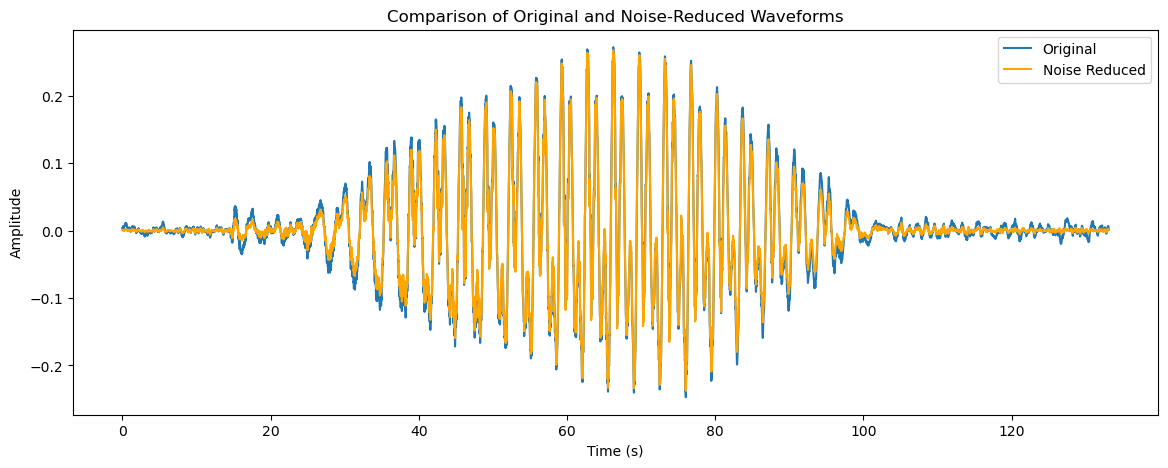

In [38]:
import noisereduce as nr
import soundfile as sf
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

# Load the original audio file
original_data, samplerate = sf.read(audio_file)

# Reduce noise
reduced_noise_data = nr.reduce_noise(y=original_data, sr=samplerate)

# Plot both original and noise-reduced waveforms together
time_original = librosa.times_like(original_data, sr=samplerate)
time_reduced = librosa.times_like(reduced_noise_data, sr=samplerate)

plt.figure(figsize=(14, 5))

# Plot original waveform
plt.plot(time_original, original_data, label='Original')

# Plot noise-reduced waveform with orangish color
plt.plot(time_reduced, reduced_noise_data, label='Noise Reduced', color='orange', alpha=1)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Comparison of Original and Noise-Reduced Waveforms')
plt.legend()
plt.show()
